In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from seaborn import load_dataset

from catboost import CatBoostRegressor


In [17]:
data = load_dataset("dowjones")
data.columns = [col.lower() for col in data.columns]
data.info()
data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    649 non-null    datetime64[ns]
 1   price   649 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.3 KB


,date,price
0,1914-12-01,55.00
1,1915-01-01,56.55
2,1915-02-01,56.00
3,1915-03-01,58.30
4,1915-04-01,66.45
...,...,...
644,1968-08-01,883.72
645,1968-09-01,922.80
646,1968-10-01,955.47
647,1968-11-01,964.12


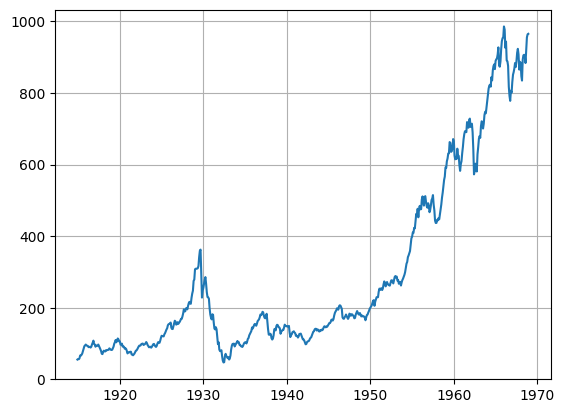

In [18]:
plt.plot(data["date"], data["price"])
plt.grid()
plt.show()


### Create feats

In [19]:
def create_feats(df, periods=None, feature_col="price"):
    periods = [1, 3, 6, 12, 24] if periods is None else periods
    df = df.copy()
    
    for period in periods:
        df[f"{feature_col}_lag_{period}"] = df[f"{feature_col}"].shift(period)
        df[f"{feature_col}_rolling_mean_{period}"] = df[f"{feature_col}"].rolling(period).mean()
        df[f"{feature_col}_rolling_mean_{period}_gaus"] = df[f"{feature_col}"].rolling(period, win_type="gaussian").mean(std=10)
    
    df["month"] = df["date"].dt.month
    return df
    

df_feats = create_feats(data)
df_feats


,date,price,price_lag_1,price_rolling_mean_1,price_rolling_mean_1_gaus,price_lag_3,price_rolling_mean_3,price_rolling_mean_3_gaus,price_lag_6,price_rolling_mean_6,price_rolling_mean_6_gaus,price_lag_12,price_rolling_mean_12,price_rolling_mean_12_gaus,price_lag_24,price_rolling_mean_24,price_rolling_mean_24_gaus,month
0,1914-12-01,55.00,NaN,55.00,55.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,1915-01-01,56.55,55.00,56.55,56.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1915-02-01,56.00,56.55,56.00,56.00,NaN,55.850000,55.851168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1915-03-01,58.30,56.00,58.30,58.30,55.00,56.950000,56.948415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,1915-04-01,66.45,58.30,66.45,66.45,56.55,60.250000,60.246747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1968-08-01,883.72,905.32,883.72,883.72,905.22,898.620000,898.631176,847.20,888.201667,888.453337,912.46,887.066667,886.294082,817.55,866.157500,869.910669,8
645,1968-09-01,922.80,883.72,922.80,922.80,906.82,903.946667,903.912928,834.76,902.875000,902.851238,923.45,887.012500,886.407479,791.65,871.622083,874.618098,9
646,1968-10-01,955.47,922.80,955.47,955.47,905.32,920.663333,920.666897,893.37,913.225000,913.048765,907.54,891.006667,890.475741,778.10,879.012500,880.359046,10
647,1968-11-01,964.12,955.47,964.12,964.12,883.72,947.463333,947.476689,905.22,923.041667,922.892881,865.43,899.230833,898.585129,806.55,885.577917,885.548507,11


In [33]:
def create_target(df, horizon=1):
    df = df.copy()
    df["target"] = df["price"].shift(-horizon)
    return df.drop("price", axis=1).dropna()


def time_split(X, y, time_col="date", train_size=0.85):
    if len(X) != len(y):
        X = X[X[time_col].isin(y[time_col])]
        
    X = X.sort_values(time_col).drop(time_col, axis=1)
    y = y.sort_values(time_col).drop(time_col, axis=1)
    split = int(len(X) * train_size)
    
    return X[:split], X[split:], y[:split], y[split:]


df_target_1 = create_target(data)
df_target_1
    

,date,target
0,1914-12-01,56.55
1,1915-01-01,56.00
2,1915-02-01,58.30
3,1915-03-01,66.45
4,1915-04-01,65.95
...,...,...
643,1968-07-01,883.72
644,1968-08-01,922.80
645,1968-09-01,955.47
646,1968-10-01,964.12


In [43]:
def virt_ensemble(X_train, y_train, X_test, num_samples=10, iters=1000, lr=0.2, seed=42):
    ens_preds = []
    model = CatBoostRegressor(
        iterations=iters,
        learning_rate=lr,
        loss_function="RMSEWithUncertainty", 
        posterior_sampling=True,
        verbose=False, 
        random_seed=seed,
        allow_writing_files=False
    )
    model.fit(X_train, y_train)
    ens_preds = model.virtual_ensembles_predict(X_test, prediction_type="TotalUncertainty", virtual_ensembles_count=num_samples)
    
    return model, ens_preds


In [44]:
X_train, X_test, y_train_1, y_test_1 = time_split(df_feats, df_target_1)

model_1, ens_1 = virt_ensemble(X_train, y_train_1, X_test)


/Users/gleb/opt/anaconda3/envs/new_base/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


`TotalUncertainty` yields mean (across ensemble) prediction, data uncertainty, knowledge uncertainty


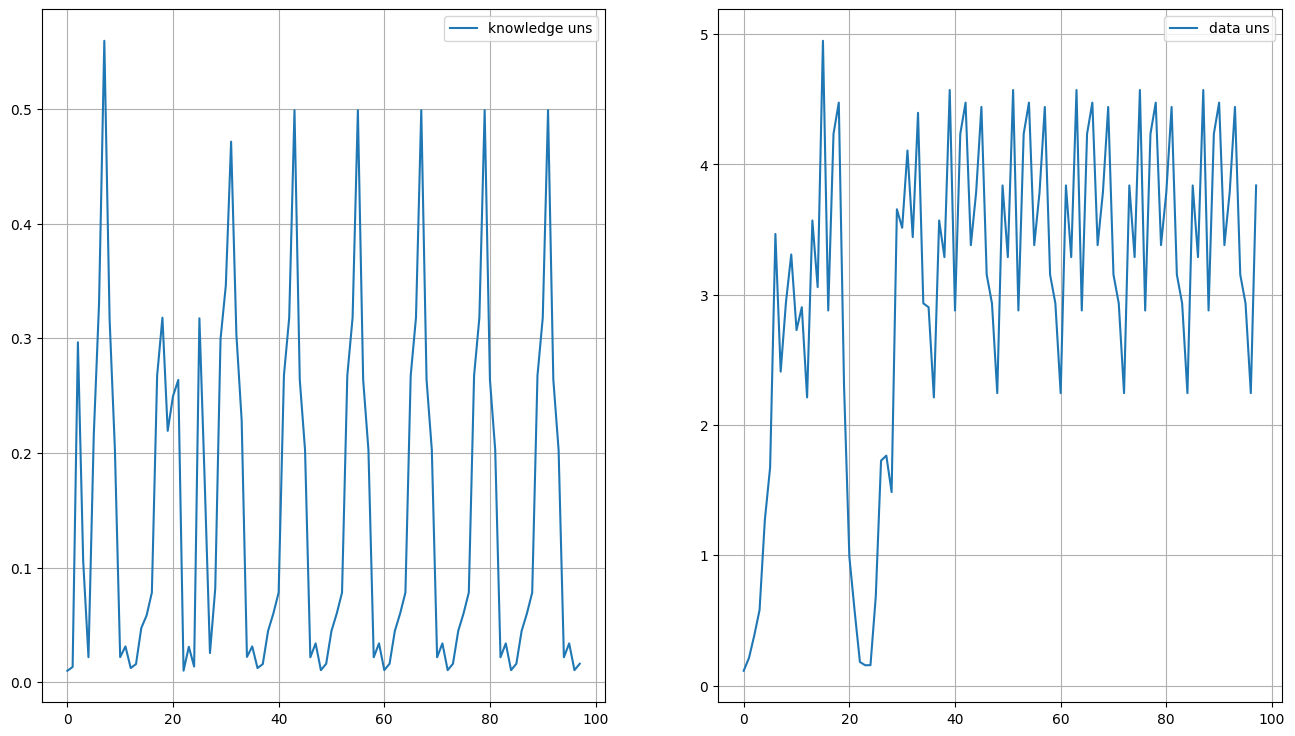

In [63]:
mean_preds = ens_1[:, 0]
know = ens_1[:, 1]
data = ens_1[:, 2]

fig, ax = plt.subplots(1, 2, figsize=(16, 9))
ax[0].plot(know, label="knowledge uns")
ax[0].grid()
ax[0].legend()
ax[1].plot(data, label="data uns")
ax[1].grid()
ax[1].legend()

plt.show()


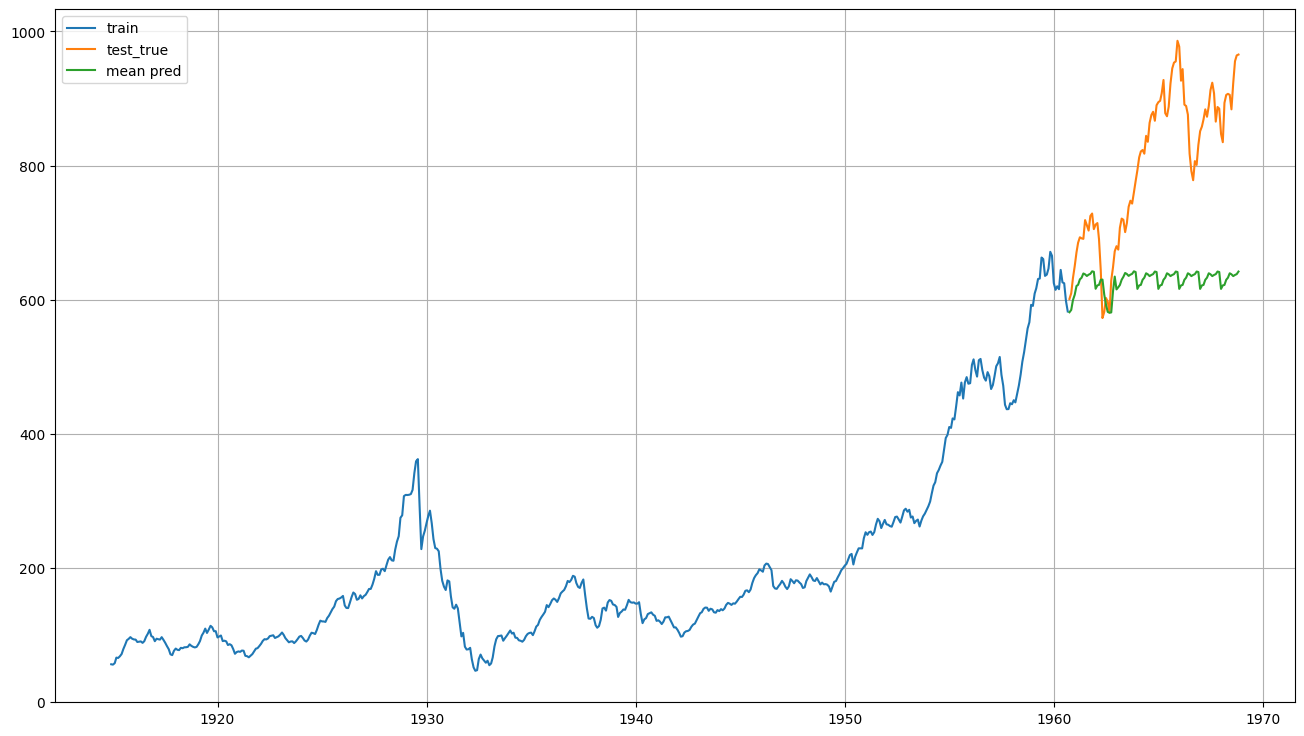

In [66]:
plt.figure(figsize=(16, 9))
plt.plot(
    df_target_1["date"].iloc[:len(y_train_1)],
    df_target_1["target"].iloc[:len(y_train_1)],
    label="train"
)

plt.plot(
    df_target_1["date"].iloc[len(y_train_1):],
    df_target_1["target"].iloc[len(y_train_1):],
    label="test_true"
)

plt.plot(
    df_target_1["date"].iloc[len(y_train_1):],
    mean_preds,
    label="mean pred"
)
plt.legend()
plt.grid()
plt.show()


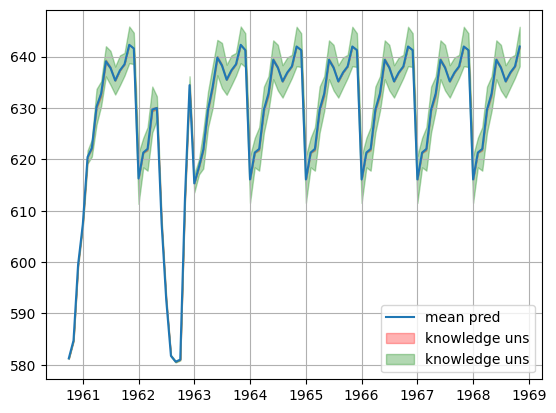

In [67]:
plt.plot(
    df_target_1["date"].iloc[len(y_train_1):],
    mean_preds,
    label="mean pred"
)

plt.fill_between(
    df_target_1["date"].iloc[len(y_train_1):],
    # Predictions +- know uns
    mean_preds + know,
    mean_preds - know,
    alpha=0.3,
    color="red",
    label="knowledge uns"
)

plt.fill_between(
    df_target_1["date"].iloc[len(y_train_1):],
    # Predictions +- know uns
    mean_preds + data,
    mean_preds - data,
    alpha=0.3,
    color="green",
    label="knowledge uns"
)

plt.legend()
plt.grid()
plt.show()
